In [0]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 8.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
from __future__ import print_function
%tensorflow_version 1.x
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import InceptionV3
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import regularizers
import tensorflow as tf
from keras import initializers, layers

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

In [0]:
# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

In [0]:
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """
        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [0]:
input_image = Input(shape=(800, 800, 3))
x = MaxPooling2D((2, 2))(input_image)

# A InceptionResNetV2 Conv2D model
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=x)

base_model.summary()





58892288/58889256 [==============================] - 2s 0us/step






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 800, 800, 3)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
b

In [0]:
for layer in base_model.layers:
    layer.trainable = False

In [0]:
output = Conv2D(256, kernel_size=(9, 9), strides=(1, 1), activation='relu')(base_model.get_layer(name='block4_pool').output)
x =  Dropout(0.25)(output)
x = Reshape((-1, 128))(x)
capsule = Capsule(2, 16, 2, True)(x)
x1 = Flatten()(capsule)
x = Dropout(0.5)(x1)
output = Dense(1, activation='sigmoid')(x)
# output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model1 = Model(inputs=input_image, outputs=output)
model1.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 800, 800, 3)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
__________________________

In [0]:
import keras

In [0]:
opt = keras.optimizers.Adam(lr=1e-3)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
img_height, img_width = 800, 800
batch_size = 14

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
train_folder = '/content/drive/My Drive/sort/train'
validation_folder = '/content/drive/My Drive/sort/validation/'

In [0]:
train_datagen = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    rescale=1./255,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range=0.2,
                    zoom_range=0.2
                    
                    )
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255,
                                 rotation_range=10,
                                 horizontal_flip=True,
                                 vertical_flip=True
                               )

In [0]:
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=['one-person', 'more-than-one']
    ) # set as training data

validation_generator = val_datagen.flow_from_directory(
    validation_folder, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=['one-person', 'more-than-one']
    ) # set as validation data

Found 6733 images belonging to 2 classes.
Found 1675 images belonging to 2 classes.


In [0]:
test_generator = test_datagen.flow_from_directory(
                    '/content/drive/My Drive/test/',
                    target_size=(img_height, img_width),
                    batch_size=30,
                    shuffle=True,
                    class_mode='binary',
                    classes=['one-person', 'more-than-one'])

Found 2940 images belonging to 2 classes.


In [0]:
lr=1e-4
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/vg2.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='min')

In [0]:
early = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

callback_list = [checkpoint, early]

In [0]:
model1.load_weights('/content/drive/My Drive/Colab Notebooks/vg1.h5')

In [0]:
history = model1.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 5,
    callbacks=callback_list)



Epoch 1/5
1333/1333 [==============================] - 19328s 14s/step - loss: 0.4861 - acc: 0.7692 - val_loss: 0.4807 - val_acc: 0.7611

Epoch 00001: val_loss improved from inf to 0.48073, saving model to /content/drive/My Drive/Colab Notebooks/vg2.h5
Epoch 2/5
1333/1333 [==============================] - 2120s 2s/step - loss: 0.4621 - acc: 0.7884 - val_loss: 0.4533 - val_acc: 0.7851

Epoch 00002: val_loss improved from 0.48073 to 0.45335, saving model to /content/drive/My Drive/Colab Notebooks/vg2.h5
Epoch 3/5
1333/1333 [==============================] - 2101s 2s/step - loss: 0.4530 - acc: 0.7896 - val_loss: 0.4457 - val_acc: 0.7911

Epoch 00003: val_loss improved from 0.45335 to 0.44568, saving model to /content/drive/My Drive/Colab Notebooks/vg2.h5
Epoch 4/5
1333/1333 [==============================] - 2093s 2s/step - loss: 0.4432 - acc: 0.7993 - val_loss: 0.4334 - val_acc: 0.8022

Epoch 00004: val_loss improved from 0.44568 to 0.43344, saving model to /content/drive/My Drive/Col

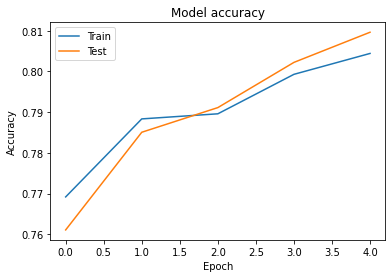

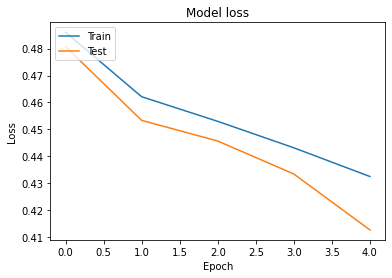

In [0]:
import matplotlib.pyplot as plt


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model1.load_weights('/content/drive/My Drive/Colab Notebooks/vg2.h5')

In [0]:
print(model1.evaluate_generator(train_generator, train_generator.samples // batch_size))

[0.398050120313858, 0.8201474768491763]


In [0]:
print(model1.evaluate_generator(test_generator, test_generator.samples // 30))

[0.3735845180190339, 0.8431972733565739]


## Data with overlapped objects

In [0]:
my_callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath = '/content/drive/My Drive/Colab Notebooks/capsoverlap.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [0]:
history = model1.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 5,
    callbacks=my_callbacks)



Epoch 1/5
673/673 [==============================] - 3028s 4s/step - loss: 0.3479 - acc: 0.8562 - val_loss: 0.3883 - val_acc: 0.8198

Epoch 00001: val_loss improved from inf to 0.38833, saving model to /content/drive/My Drive/Colab Notebooks/capsoverlap.h5
Epoch 2/5
673/673 [==============================] - 155s 230ms/step - loss: 0.3227 - acc: 0.8703 - val_loss: 0.3707 - val_acc: 0.8336

Epoch 00002: val_loss improved from 0.38833 to 0.37066, saving model to /content/drive/My Drive/Colab Notebooks/capsoverlap.h5
Epoch 3/5
673/673 [==============================] - 153s 227ms/step - loss: 0.3090 - acc: 0.8799 - val_loss: 0.4118 - val_acc: 0.8336

Epoch 00003: val_loss did not improve from 0.37066
Epoch 4/5
673/673 [==============================] - 152s 227ms/step - loss: 0.2970 - acc: 0.8825 - val_loss: 0.3922 - val_acc: 0.8462

Epoch 00004: val_loss did not improve from 0.37066
Epoch 5/5
673/673 [==============================] - 150s 223ms/step - loss: 0.2807 - acc: 0.8948 - val_

In [0]:
model1.load_weights('/content/drive/My Drive/Colab Notebooks/capsoverlap.h5')

In [0]:
print(model1.evaluate_generator(validation_generator, validation_generator.samples // batch_size))

[0.6087966819114529, 0.7484909458339494]


In [ ]:
my_callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath = '/content/drive/My Drive/Colab Notebooks/capsoverlap1.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [0]:
history = model1.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 20,
    callbacks=my_callbacks)

Epoch 1/20
673/673 [==============================] - 866s 1s/step - loss: 0.3311 - acc: 0.8636 - val_loss: 0.3631 - val_acc: 0.8455

Epoch 00001: val_loss improved from inf to 0.36314, saving model to /content/drive/My Drive/Colab Notebooks/capsoverlap1.h5
Epoch 2/20
673/673 [==============================] - 836s 1s/step - loss: 0.3256 - acc: 0.8653 - val_loss: 0.3837 - val_acc: 0.8366

Epoch 00002: val_loss did not improve from 0.36314
Epoch 3/20
673/673 [==============================] - 831s 1s/step - loss: 0.3159 - acc: 0.8706 - val_loss: 0.4012 - val_acc: 0.8288

Epoch 00003: val_loss did not improve from 0.36314
Epoch 4/20
673/673 [==============================] - 825s 1s/step - loss: 0.3123 - acc: 0.8737 - val_loss: 0.3772 - val_acc: 0.8396

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_loss did not improve from 0.36314
Epoch 5/20
673/673 [==============================] - 826s 1s/step - loss: 0.2908 - acc: 0.8829 - val_los